In [1]:
#Importing required libraries
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from textblob import Word

import wordcloud
from wordcloud import WordCloud

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf

import random

from transformers import BertTokenizer, TFBertForSequenceClassification, InputExample, InputFeatures

In [2]:
df_company_tweet  = pd.read_csv("/kaggle/input/tweets-about-the-top-companies-from-2015-to-2020/Company_Tweet.csv")
df_tweet = pd.read_csv("/kaggle/input/tweets-about-the-top-companies-from-2015-to-2020/Tweet.csv")

In [3]:
# Merging tweets with the corresponding comapny ID
tweets = pd.merge(df_company_tweet,df_tweet,on= "tweet_id", how = "inner")

In [4]:
tweets.dropna(inplace = True)

In [5]:
tweets['post_date'] = pd.to_datetime(tweets["post_date"],utc = False , unit = 's',).dt.normalize()
tweets.head()

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num
0,550803612197457920,AAPL,SentiQuant,2015-01-01,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1
1,550803612197457920,AMZN,SentiQuant,2015-01-01,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1
2,550803610825928706,AAPL,SentiQuant,2015-01-01,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1
3,550803610825928706,GOOGL,SentiQuant,2015-01-01,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1
4,550803610825928706,AMZN,SentiQuant,2015-01-01,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1


In [6]:
# Filtering tweets to only keep those with >= 50 activities 
tweets["tweet_activity"] = tweets["comment_num"] + tweets["like_num"] + tweets["retweet_num"]
filterTweets = tweets.loc[tweets["tweet_activity"] > 50]
filterTweets.head()

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,tweet_activity
40,550781053137616896,AAPL,CNBC,2015-01-01,This is Wall Street's top pick in 2015. Hint: ...,5,37,22,64
47,550779709840445441,AAPL,WSJ,2015-01-01,"See how tech companies like Apple, Twitter and...",15,223,109,347
242,550650451948212224,AAPL,greatspoke,2015-01-01,Top Stock Analyst Releases Report on Top Stock...,0,431,2,433
243,550650235404701697,AAPL,greatspoke,2015-01-01,Analyst Report on Top Stock Market Options for...,0,430,3,433
244,550650235404701697,AMZN,greatspoke,2015-01-01,Analyst Report on Top Stock Market Options for...,0,430,3,433


In [7]:
def removeStopWords(df):
    finalList = []
    stop_words = set(stopwords.words('english'))
    for word in df:
        if word not in stop_words:
            finalList.append(word)
    df = finalList
    return df

In [8]:
import re

def clean_dataframe_text(df, column):
    
    
    # Remove any non-alphanumeric characters and replace them with spaces
    df[column] = df[column].apply(lambda x: re.sub(r"(\w+)'d", lambda m: 'would' if m.group(1) in ['he', 'she', 'it', 'that'] else 'had', x))
    
    # Replace 's with 'is' or 'has'
    df[column] = df[column].apply(lambda x: re.sub(r"(\w+)'s", lambda m: 'is' if m.group(1) in ['he', 'she', 'it'] else 'has', x))
    
    # Remove any non-alphanumeric characters and replace them with spaces
    df[column] = df[column].apply(lambda x: re.sub(r'[^\w\s]', '', x))
    
    # Replace any consecutive whitespace characters with a single space
    df[column] = df[column].apply(lambda x: re.sub(r'\s+', ' ', x))
    
    df[column] = df[column].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
    
    # Replace any consecutive whitespace characters with a single space
    df[column] = df[column].apply(lambda x: re.sub(r'\s+', ' ', x))
    
    df[column] = df[column].apply(lambda x: re.sub(r'\d+', '', x))
    
    # Convert the string in lower
    df[column] = df[column].str.lower()
    
    # Tokenised the words
    df[column]  = df[column].apply(lambda x : nltk.word_tokenize(x))

    # Remove stopwords from the NLTK stopword list
    df[column] = df[column].apply(lambda x : removeStopWords(x))
    
    #concatenate the tokenised list into string
    df[column] = df[column].apply(lambda x: ' '.join(x))
    
      
    return df

In [9]:
clean_dataframe_text(filterTweets,"body")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,tweet_activity
40,550781053137616896,AAPL,CNBC,2015-01-01,wall top pick hint aapl googl httpcnbcxxsbwit,5,37,22,64
47,550779709840445441,AAPL,WSJ,2015-01-01,see tech companies like apple twitter facebook...,15,223,109,347
242,550650451948212224,AAPL,greatspoke,2015-01-01,top stock analyst releases report top stocks e...,0,431,2,433
243,550650235404701697,AAPL,greatspoke,2015-01-01,analyst report top stock market options read a...,0,430,3,433
244,550650235404701697,AMZN,greatspoke,2015-01-01,analyst report top stock market options read a...,0,430,3,433
...,...,...,...,...,...,...,...,...,...
4336315,1212102520455208960,TSLA,ElonsWorld,2019-12-31,china biggest auto ev market world become larg...,2,5,58,65
4336316,1212102550327037952,TSLA,TeslaPodcast,2019-12-31,nice little surprise find grocery store today ...,39,23,521,583
4336341,1212110813093339141,TSLA,ValueAnalyst1,2019-12-31,dumb question enough people run car factory ts...,4,3,49,56
4336342,1212111064730603521,TSLA,freshjiva,2019-12-31,top picks particular ordertslaslvabbvboxabmdbt...,11,8,66,85


In [10]:
from textblob import TextBlob
# Function to use TextBlob (Sentimental Analysis [Objectivity & Polarity])

def add_sentiment_scores_blob(df, text_column, polarity_threshold = 0.0 , subjectivity_threshold = 0.5):
    # Compute polarity and subjectivity scores for each row in the specified text column
    scores = df[text_column].apply(lambda x: TextBlob(x).sentiment)
    
    # Add two new columns to the DataFrame for the polarity and subjectivity scores
    df['blob_polarity'] = scores.apply(lambda x: x.polarity)
    df['blob_subjectivity'] = scores.apply(lambda x: x.subjectivity)
    
    # Convert polarity score to class (positive, neutral, or negative) based on the specified threshold
    df['blob_polarity'] = df['blob_polarity'].apply(lambda x: 'Positive' if x > polarity_threshold else 'Negative' if x < -polarity_threshold else 'Neutral')
    
    # Convert subjectivity score to class (subjective or objective) based on the specified threshold
    df['blob_subjectivity'] = df['blob_subjectivity'].apply(lambda x: 'Subjective' if x > subjectivity_threshold else 'Objective')
    
    return df


In [11]:
add_sentiment_scores_blob(filterTweets,"body", 0.0, 0.5)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,tweet_activity,blob_polarity,blob_subjectivity
40,550781053137616896,AAPL,CNBC,2015-01-01,wall top pick hint aapl googl httpcnbcxxsbwit,5,37,22,64,Positive,Objective
47,550779709840445441,AAPL,WSJ,2015-01-01,see tech companies like apple twitter facebook...,15,223,109,347,Negative,Subjective
242,550650451948212224,AAPL,greatspoke,2015-01-01,top stock analyst releases report top stocks e...,0,431,2,433,Positive,Objective
243,550650235404701697,AAPL,greatspoke,2015-01-01,analyst report top stock market options read a...,0,430,3,433,Positive,Objective
244,550650235404701697,AMZN,greatspoke,2015-01-01,analyst report top stock market options read a...,0,430,3,433,Positive,Objective
...,...,...,...,...,...,...,...,...,...,...,...
4336315,1212102520455208960,TSLA,ElonsWorld,2019-12-31,china biggest auto ev market world become larg...,2,5,58,65,Negative,Subjective
4336316,1212102550327037952,TSLA,TeslaPodcast,2019-12-31,nice little surprise find grocery store today ...,39,23,521,583,Positive,Subjective
4336341,1212110813093339141,TSLA,ValueAnalyst1,2019-12-31,dumb question enough people run car factory ts...,4,3,49,56,Negative,Objective
4336342,1212111064730603521,TSLA,freshjiva,2019-12-31,top picks particular ordertslaslvabbvboxabmdbt...,11,8,66,85,Positive,Objective


In [12]:
sentiment_map = {"Positive": 1, "Negative": 0, "Neutral": 2}
filterTweets["blob_polarity"].replace(sentiment_map, inplace = True)

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [13]:
filterTweets

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,tweet_activity,blob_polarity,blob_subjectivity
40,550781053137616896,AAPL,CNBC,2015-01-01,wall top pick hint aapl googl httpcnbcxxsbwit,5,37,22,64,1,Objective
47,550779709840445441,AAPL,WSJ,2015-01-01,see tech companies like apple twitter facebook...,15,223,109,347,0,Subjective
242,550650451948212224,AAPL,greatspoke,2015-01-01,top stock analyst releases report top stocks e...,0,431,2,433,1,Objective
243,550650235404701697,AAPL,greatspoke,2015-01-01,analyst report top stock market options read a...,0,430,3,433,1,Objective
244,550650235404701697,AMZN,greatspoke,2015-01-01,analyst report top stock market options read a...,0,430,3,433,1,Objective
...,...,...,...,...,...,...,...,...,...,...,...
4336315,1212102520455208960,TSLA,ElonsWorld,2019-12-31,china biggest auto ev market world become larg...,2,5,58,65,0,Subjective
4336316,1212102550327037952,TSLA,TeslaPodcast,2019-12-31,nice little surprise find grocery store today ...,39,23,521,583,1,Subjective
4336341,1212110813093339141,TSLA,ValueAnalyst1,2019-12-31,dumb question enough people run car factory ts...,4,3,49,56,0,Objective
4336342,1212111064730603521,TSLA,freshjiva,2019-12-31,top picks particular ordertslaslvabbvboxabmdbt...,11,8,66,85,1,Objective


## BERT
### Preparing BERT

In [14]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=5)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  3845      
                                                                 
Total params: 109,486,085
Trainable params: 109,486,085
Non-trainable params: 0
_________________________________________________________________


In [16]:
def split_dataset(df, test_size, random_state):
    df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
    return df_train, df_test

In [17]:
# create train:test:validation = 6:2:2
# split a validation set
train_test, validation = split_dataset(filterTweets, test_size=0.2, random_state=0) 
# split train & test
train, test = split_dataset(train_test, test_size=0.25, random_state=0) 

In [18]:
print(filterTweets.shape)
print(train_test.shape)
print(train.shape)
print(test.shape)
print(validation.shape)

(41625, 11)
(33300, 11)
(24975, 11)
(8325, 11)
(8325, 11)


In [19]:
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
    train_InputExamples = train.apply(lambda x: InputExample(guid=None, #Globally unique ID for bookkeeping, unused in this case
                                                           text_a=x[DATA_COLUMN],
                                                           text_b=None,
                                                           label=x[LABEL_COLUMN]), axis=1)

    validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                               text_a=x[DATA_COLUMN],
                                                               text_b=None,
                                                               label=x[LABEL_COLUMN]), axis=1)

    return train_InputExamples, validation_InputExamples

    train_InputExamples, validation_InputExamples = convert_data_to_examples(train, test, 'DATA_COLUMN', 'LABEL_COLUMN')
    
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )

In [20]:
DATA_COLUMN = 'body'
LABEL_COLUMN = 'blob_polarity'

In [21]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN)

In [22]:
train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2345: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


### Run Model

In [23]:
train_data = train_data.shuffle(100).batch(64)
#.repeat(2)
validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(64)

In [24]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_sc_accuracy', patience=2, restore_best_weights=True)

In [25]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=5)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-8, clipnorm=1.0), #lr=3e-5, eps=01e-8 #clipnorm=1.0
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy('sc_accuracy')]
)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
history = model.fit(
    train_data,
    epochs=4,
    validation_data=validation_data,
    callbacks=[callback]
    #class_weight=class_weight
)

Epoch 1/4
391/391 [==============================] - 690s 2s/step - loss: 0.5477 - sc_accuracy: 0.7839 - val_loss: 0.3067 - val_sc_accuracy: 0.9049
Epoch 2/4
391/391 [==============================] - 642s 2s/step - loss: 0.1966 - sc_accuracy: 0.9403 - val_loss: 0.1992 - val_sc_accuracy: 0.9380
Epoch 3/4
391/391 [==============================] - 643s 2s/step - loss: 0.1183 - sc_accuracy: 0.9646 - val_loss: 0.1898 - val_sc_accuracy: 0.9461
Epoch 4/4
391/391 [==============================] - 642s 2s/step - loss: 0.0783 - sc_accuracy: 0.9766 - val_loss: 0.2194 - val_sc_accuracy: 0.9464


### Preparing Test Set

In [27]:
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )

In [28]:
def convert_data_to_examples(data, DATA_COLUMN, LABEL_COLUMN): 

    data_InputExamples = data.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                         text_a=x[DATA_COLUMN],
                                                         text_b=None,
                                                         label=x[LABEL_COLUMN]), axis=1)

    return data_InputExamples

    train_InputExamples, validation_InputExamples = convert_data_to_examples(train, 
                                                                           test, 
                                                                           'DATA_COLUMN', 
                                                                           'LABEL_COLUMN')

In [29]:
DATA_COLUMN = 'body'
LABEL_COLUMN = 'blob_polarity'

In [30]:
y_test = list(validation[LABEL_COLUMN])

In [31]:
test_InputExamples = convert_data_to_examples(validation, DATA_COLUMN, LABEL_COLUMN)

In [32]:
test_data = convert_examples_to_tf_dataset(list(test_InputExamples), tokenizer)
test_data = test_data.batch(64)

### Prediction

In [33]:
preds = model.predict(test_data)

131/131 [==============================] - 69s 502ms/step


In [34]:
preds.logits

array([[-1.6027638 ,  6.240494  , -2.1194005 , -1.8775481 , -1.9114186 ],
       [-1.943715  ,  6.1295047 , -2.0369737 , -1.5986482 , -1.7657907 ],
       [ 5.11062   ,  1.0309699 ,  0.23646306, -3.3643122 , -3.080409  ],
       ...,
       [-1.5221118 , -0.5794067 ,  5.936808  , -2.5353718 , -2.122068  ],
       [-1.9606079 ,  6.195959  , -1.6966493 , -1.9276869 , -1.9684106 ],
       [ 4.4485803 ,  2.015597  ,  0.26275548, -3.6116018 , -3.396619  ]],
      dtype=float32)

In [35]:
label = tf.argmax(preds.logits, axis=1)
label = label.numpy()

In [36]:
label

array([1, 1, 0, ..., 2, 1, 0])

### Performance Metrics

In [37]:
sklearn.metrics.confusion_matrix(label, y_test)

array([[1389,   41,   21],
       [ 205, 3815,   61],
       [  39,   27, 2727]])

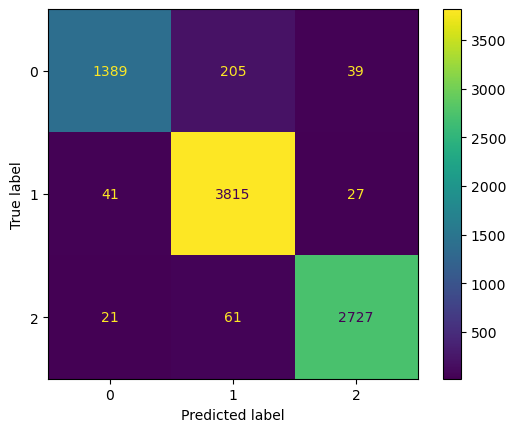

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, label)

In [39]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, label)

0.9526726726726726

In [40]:
from sklearn.metrics import classification_report
print(classification_report(y_test, label))

              precision    recall  f1-score   support

           0       0.96      0.85      0.90      1633
           1       0.93      0.98      0.96      3883
           2       0.98      0.97      0.97      2809

    accuracy                           0.95      8325
   macro avg       0.96      0.93      0.94      8325
weighted avg       0.95      0.95      0.95      8325



### Export Model 

In [41]:
import os
saved_model = "textblob_saved_model_booking3"
os.makedirs(saved_model, exist_ok=True)
model.save(saved_model)

In [42]:
!zip -r textblob_saved_model_booking3.zip textblob_saved_model_booking3

  adding: textblob_saved_model_booking3/ (stored 0%)
  adding: textblob_saved_model_booking3/fingerprint.pb (stored 0%)
  adding: textblob_saved_model_booking3/keras_metadata.pb (deflated 96%)
  adding: textblob_saved_model_booking3/assets/ (stored 0%)
  adding: textblob_saved_model_booking3/saved_model.pb (deflated 93%)
  adding: textblob_saved_model_booking3/variables/ (stored 0%)
  adding: textblob_saved_model_booking3/variables/variables.data-00000-of-00001 (deflated 14%)
  adding: textblob_saved_model_booking3/variables/variables.index (deflated 79%)


In [43]:
from IPython.display import FileLink
FileLink('textblob_saved_model_booking3.zip')

/kaggle/working/textblob_saved_model_booking3.zip

## Distilled BERT

In [44]:
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification, InputExample, InputFeatures

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_transform', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_95', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [45]:
from sklearn.metrics import confusion_matrix, accuracy_score
X = filterTweets.body

#reuse train-test-val split from above

In [46]:
# create train:test:validation = 6:2:2
# split a validation set
train_test, validation = split_dataset(filterTweets, test_size=0.2, random_state=0) 
# split train & test
train, test = split_dataset(train_test, test_size=0.25, random_state=0) 

In [47]:
print(train.shape)
print(test.shape)
print(validation.shape)

(24975, 11)
(8325, 11)
(8325, 11)


In [48]:
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, #Globally unique ID for bookkeeping, unused in this case
                                                           text_a=x[DATA_COLUMN],
                                                           text_b=None,
                                                           label=x[LABEL_COLUMN]), axis=1)

  validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                               text_a=x[DATA_COLUMN],
                                                               text_b=None,
                                                               label=x[LABEL_COLUMN]), axis=1)
  
  return train_InputExamples, validation_InputExamples

  train_InputExamples, validation_InputExamples = convert_data_to_examples(train, 
                                                                           test, 
                                                                           'DATA_COLUMN', 
                                                                           'LABEL_COLUMN')
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=False,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, attention_mask = (input_dict["input_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask,  label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )

In [49]:
DATA_COLUMN = 'body'
LABEL_COLUMN = 'blob_polarity'
train_InputExamples, validation_InputExamples = convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN)

### Run Model

In [50]:
train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32)
#.repeat(2)
validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2345: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [51]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_sc_accuracy', patience=2, restore_best_weights=True)

In [52]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-05, epsilon=1e-8, clipnorm=1.0), #lr=3e-5, eps=01e-8
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy('sc_accuracy')]
)

history = model.fit(
    train_data,
    epochs=4,
    validation_data=validation_data,
    callbacks=[callback]
)

Epoch 1/4
781/781 [==============================] - 366s 437ms/step - loss: 0.4864 - sc_accuracy: 0.8146 - val_loss: 0.2725 - val_sc_accuracy: 0.9153
Epoch 2/4
781/781 [==============================] - 335s 429ms/step - loss: 0.1784 - sc_accuracy: 0.9435 - val_loss: 0.2052 - val_sc_accuracy: 0.9395
Epoch 3/4
781/781 [==============================] - 336s 430ms/step - loss: 0.1045 - sc_accuracy: 0.9682 - val_loss: 0.1869 - val_sc_accuracy: 0.9445
Epoch 4/4
781/781 [==============================] - 335s 430ms/step - loss: 0.0685 - sc_accuracy: 0.9803 - val_loss: 0.2157 - val_sc_accuracy: 0.9447


In [53]:
def convert_data_to_examples(data, DATA_COLUMN, LABEL_COLUMN): 

    data_InputExamples = data.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                         text_a=x[DATA_COLUMN],
                                                         text_b=None,
                                                         label=x[LABEL_COLUMN]), axis=1)

    return data_InputExamples

    train_InputExamples, validation_InputExamples = convert_data_to_examples(train, 
                                                                           test, 
                                                                           'DATA_COLUMN', 
                                                                           'LABEL_COLUMN')

In [54]:
y_test = list(validation['blob_polarity'])
test_InputExamples = convert_data_to_examples(validation, DATA_COLUMN, LABEL_COLUMN)
test_data = convert_examples_to_tf_dataset(list(test_InputExamples), tokenizer)
test_data = test_data.batch(32)

In [55]:
preds2 = model.predict(test_data)
tf_predictions = tf.nn.softmax(preds2[0], axis=-1)
label2 = tf.argmax(tf_predictions, axis=1)
label2 = label2.numpy()

261/261 [==============================] - 37s 136ms/step


### Performance Metrics

In [56]:
accuracy_score(y_test, label2)

0.9524324324324325

In [57]:
print(classification_report(y_test, label2))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1633
           1       0.95      0.97      0.96      3883
           2       0.98      0.96      0.97      2809

    accuracy                           0.95      8325
   macro avg       0.95      0.94      0.94      8325
weighted avg       0.95      0.95      0.95      8325



In [58]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  3845      
                                                                 
 dropout_95 (Dropout)        multiple                  0         
                                                                 
Total params: 66,957,317
Trainable params: 66,957,317
Non-trainable params: 0
_________________________________________________________________


In [59]:
y_test = list(validation['blob_polarity'])
test_InputExamples = convert_data_to_examples(validation, DATA_COLUMN, LABEL_COLUMN)
test_data = convert_examples_to_tf_dataset(list(test_InputExamples), tokenizer)
test_data = test_data.batch(32)

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2345: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


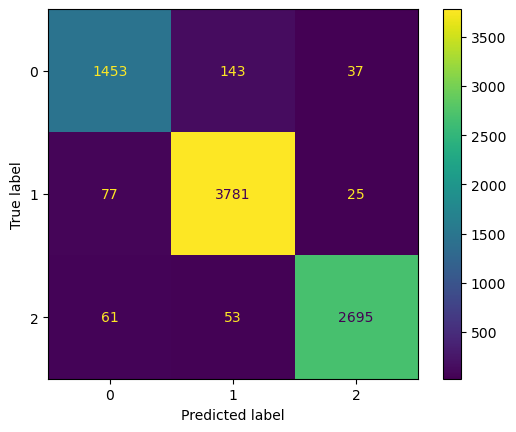

In [60]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = sklearn.metrics.confusion_matrix(y_test, label2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()